# content2vec


AUTHORS : Taisho.S

DATE : Oct 9,2019

In [1]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import multiprocessing
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from collections import Counter
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.models.word2vec as w2v
import sklearn.manifold
import time
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('../input/fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
df = df.sample(frac=1.0) # shuffle the data
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,0bbbde783aeae8edb4189d715a8a7e1e8097906e,shorty,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,english,greanvillepost.com,US
1,5290f2cd0e23cdcc8223a2483fea0298ad4fe1f1,NaN,Trump (finally) Plays Antiwar Card (a little),License DMCA \nI woke up yesterday (Thursday) ...,english,opednews.com,US
2,f525bc93909a5bb64ae0515a711457503d20f9d2,OK,Twitter dresses up for Halloween: Read the 9 s...,"— Rosie Percy (@rosiepercy) October 27, 2016 5...",english,thepoke.co.uk,GB
3,3ac46a0d52636cdeda04b0093eeb609a1c059c69,NaN,Nate Silver Gunned Down Attempting To Cross Me...,Nate Silver Gunned Down Attempting To Cross Me...,english,theonion.com,US
4,06ed682ad62c81a271baf151e319278ea832432e,NaN,TRUNEWS 10/26/16 Jeremy Wiles | Sing A Little ...,"TRUNEWS 10/26/16 Jeremy Wiles | October 26, ...",english,trunews.com,US


In [3]:
example_text = "Hi there! Good morning Mr. Smith. You should check out www.example.com, its a great website"
nltk.sent_tokenize(example_text)

['Hi there!',
 'Good morning Mr. Smith.',
 'You should check out www.example.com, its a great website']

In [4]:
def sent_tokenizer(text):
    """
    Function to tokenize sentences
    """
    text = nltk.sent_tokenize(text)
    return text

def sentence_cleaner(text):
    """
    Function to lower case remove all websites, emails and non alphabetical characters
    """
    new_text = []
    for sentence in text:
        sentence = sentence.lower()
        sentence = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", sentence)
        sentence = re.sub("[^a-z ]", "", sentence)
        sentence = nltk.word_tokenize(sentence)
        sentence = [word for word in sentence if len(word)>1] # exclude 1 letter words
        new_text.append(sentence)
    return new_text

def apply_all(text):
    return sentence_cleaner(sent_tokenizer(text))

In [5]:
t1 = time.time()
df['sent_tokenized_text'] = df['text'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 3.9861744244893393 min


In [6]:
df.head()

,uuid,author,title,text,language,site_url,country,sent_tokenized_text
0,0bbbde783aeae8edb4189d715a8a7e1e8097906e,shorty,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,english,greanvillepost.com,US,"[[dispatches, from, eric, zuesse, this, piece,..."
1,5290f2cd0e23cdcc8223a2483fea0298ad4fe1f1,NaN,Trump (finally) Plays Antiwar Card (a little),License DMCA \nI woke up yesterday (Thursday) ...,english,opednews.com,US,"[[license, dmca, woke, up, yesterday, thursday..."
2,f525bc93909a5bb64ae0515a711457503d20f9d2,OK,Twitter dresses up for Halloween: Read the 9 s...,"— Rosie Percy (@rosiepercy) October 27, 2016 5...",english,thepoke.co.uk,GB,"[[rosie, percy, october], [for, halloween, im,..."
3,3ac46a0d52636cdeda04b0093eeb609a1c059c69,NaN,Nate Silver Gunned Down Attempting To Cross Me...,Nate Silver Gunned Down Attempting To Cross Me...,english,theonion.com,US,"[[nate, silver, gunned, down, attempting, to, ..."
4,06ed682ad62c81a271baf151e319278ea832432e,NaN,TRUNEWS 10/26/16 Jeremy Wiles | Sing A Little ...,"TRUNEWS 10/26/16 Jeremy Wiles | October 26, ...",english,trunews.com,US,"[[trunews, jeremy, wiles, october, will, deuts..."


In [7]:
# create a list of all words using list comprehension
all_words = [word for item in list(df['sent_tokenized_text']) for word in item]
all_words = [subitem for item in all_words for subitem in item]

In [8]:
fdist = FreqDist(all_words)
len(fdist) # number of unique words

114924

In [9]:
# show the most common words and their counts corpus wide
fdist.most_common(20)

[('the', 474135),
 ('to', 223585),
 ('of', 223417),
 ('and', 205429),
 ('in', 149168),
 ('that', 108577),
 ('is', 101033),
 ('for', 72155),
 ('on', 59705),
 ('it', 56437),
 ('as', 53156),
 ('with', 50873),
 ('are', 48235),
 ('this', 47839),
 ('by', 44737),
 ('be', 43030),
 ('was', 41690),
 ('have', 39794),
 ('not', 38503),
 ('from', 34717)]

In [10]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('cambodias', 3),
 ('instep', 3),
 ('labovitz', 3),
 ('lahaina', 3),
 ('ganyata', 3),
 ('goldsmiths', 3),
 ('reesmogg', 3),
 ('ious', 3),
 ('timjowers', 3),
 ('productservice', 3)]

In [11]:
# choose k and visually inspect the bottom 10 words of the top k
k = 30000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('washingtonpolitical', 7),
 ('archenemy', 7),
 ('kennan', 7),
 ('prodonald', 7),
 ('reacher', 7),
 ('dives', 7),
 ('craving', 7),
 ('kellogg', 7),
 ('julys', 7),
 ('kurdishcontrolled', 7)]

In [12]:
# get document lengths to plot histogram
def doc_length(text):
    return len([word for sent in text for word in sent])

In [13]:
# document length
df['doc_len'] = df['sent_tokenized_text'].apply(doc_length)
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

In [14]:
print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 615.7995468155701 
maximum document length 22894


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


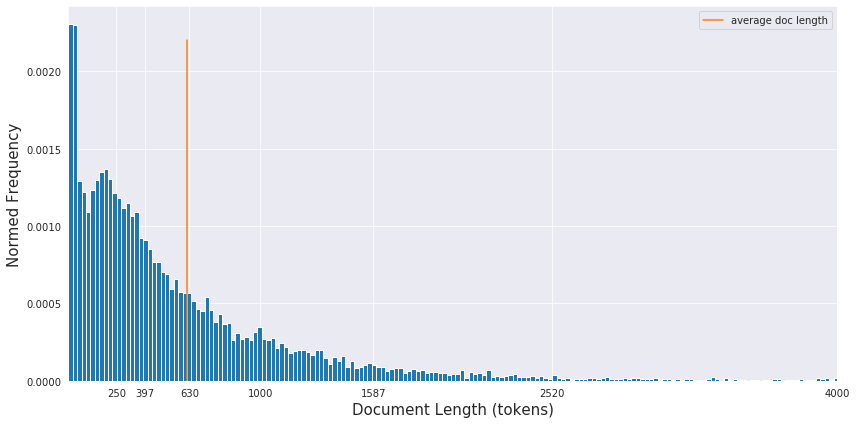

In [15]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(250),stop=np.log10(4000),num=7, base=10.0))
plt.xlim(0,4000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0022,100)], np.linspace(0.0,0.0022,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [16]:
all_sentences = list(df['sent_tokenized_text'])
all_sentences = [subitem for item in all_sentences for subitem in item]
all_sentences[:2] # print first 5 sentences

[['dispatches',
  'from',
  'eric',
  'zuesse',
  'this',
  'piece',
  'is',
  'crossposted',
  'at',
  'strategiccultureorg',
  'the',
  'power',
  'above',
  'the',
  'us',
  'federal',
  'bureau',
  'of',
  'investigation',
  'fbi',
  'is',
  'the',
  'us',
  'attorney',
  'general',
  'and',
  'above',
  'that',
  'person',
  'the',
  'us',
  'president'],
 ['thats',
  'whom',
  'the',
  'fbi',
  'actually',
  'serves',
  'not',
  'the',
  'us',
  'public']]

In [17]:
token_count = sum([len(sentence) for sentence in all_sentences])
print("The corpus contains {0:,} tokens".format(token_count)) # total words in corpus

The corpus contains 7,609,435 tokens


In [18]:
num_features = 300 # number of dimensions
# if any words appear less than min_word_count amount of times, disregard it
# recall we saw that the bottom 10 of the top 30,000 words appear only 7 times in the corpus, so lets choose 10 here
min_word_count = 10
num_workers = multiprocessing.cpu_count()
context_size = 7 # window size around target word to analyse
downsampling = 1e-3 # downsample frequent words
seed = 1 # seed for RNG

In [19]:
# setting up model with parameters above
content2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [20]:
content2vec.build_vocab(all_sentences)

In [21]:
print("Word2Vec vocabulary length:", len(content2vec.wv.vocab))

Word2Vec vocabulary length: 25818


In [22]:
# number of sentences
content2vec.corpus_count

348219

In [23]:
# train word2vec - this may take a minute...
content2vec.train(all_sentences, total_examples=content2vec.corpus_count, epochs=content2vec.iter)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(29279492, 38047175)

In [24]:
# dense 2D matrix of word vectors
all_word_vectors_matrix = content2vec.wv.syn0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [25]:
all_word_vectors_matrix.shape # .shape[0] are the top words we are considering in training word2vec

(25818, 300)

In [26]:
# train tsne model for visualisation
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
t1 = time.time()
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
t2 = time.time()
print("time to train TSNE on", all_word_vectors_matrix.shape[0], "word vectors:", (t2-t1)/60, "min")

time to train TSNE on 25818 word vectors: 13.987533950805664 min


In [27]:
# create a dataframe *points* to store the 2D embeddings of all words
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[content2vec.wv.vocab[word].index])
            for word in content2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
def plot_region(x_bounds, y_bounds):
    """
    This function defines regions of the tsne map
    in which to zoom in on
    """
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [29]:
points.head(10)

,word,x,y
0,dispatches,37.883606,-19.016853
1,from,-1.656880,-1.931779
2,eric,40.241570,-18.113081
3,zuesse,40.442318,-18.593233
4,this,-5.427358,-2.092286
5,piece,25.051979,-24.879370
6,is,-4.842247,3.638541
7,at,4.843100,-22.323202
8,the,1.405815,1.381338
9,power,-15.092360,31.109364


In [30]:
sns.set_context("poster")

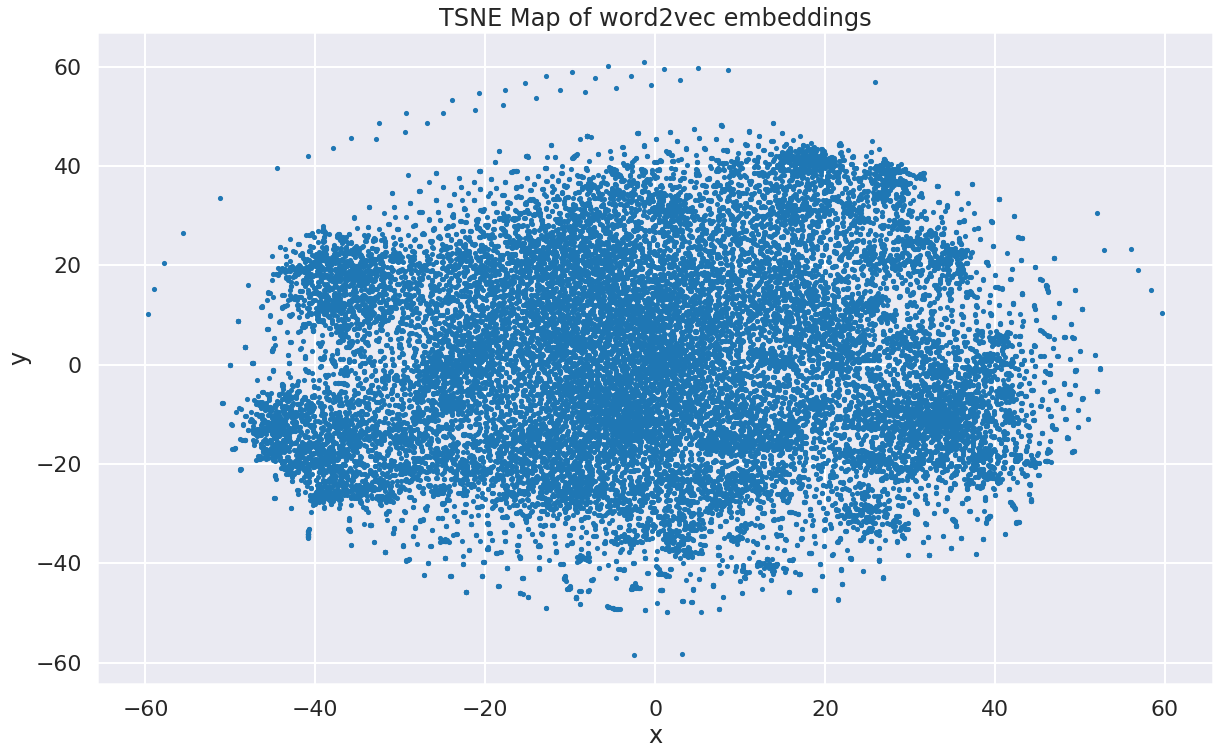

In [31]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12), title="TSNE Map of word2vec embeddings")

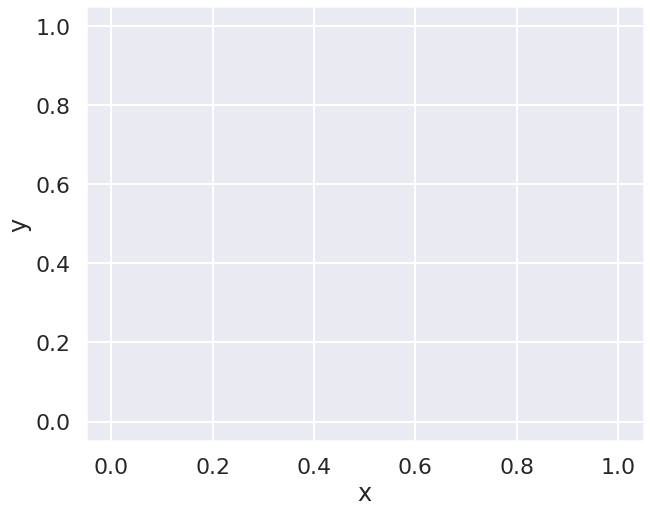

In [32]:
plot_region((3,5), (-53,-50))

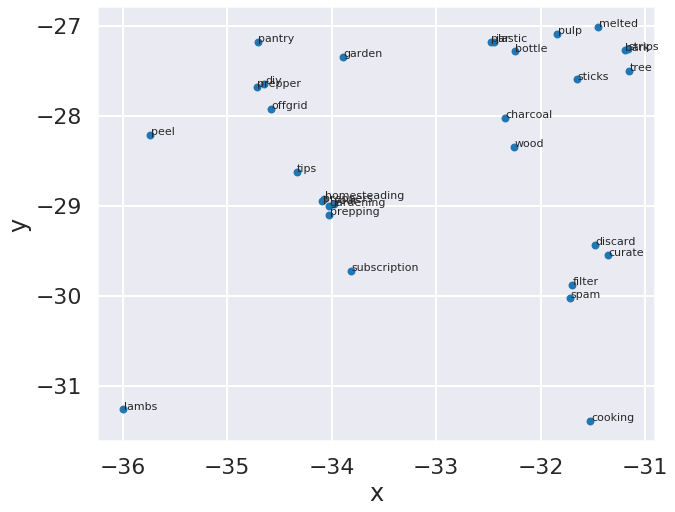

In [33]:
plot_region((-36,-31), (-32,-27))

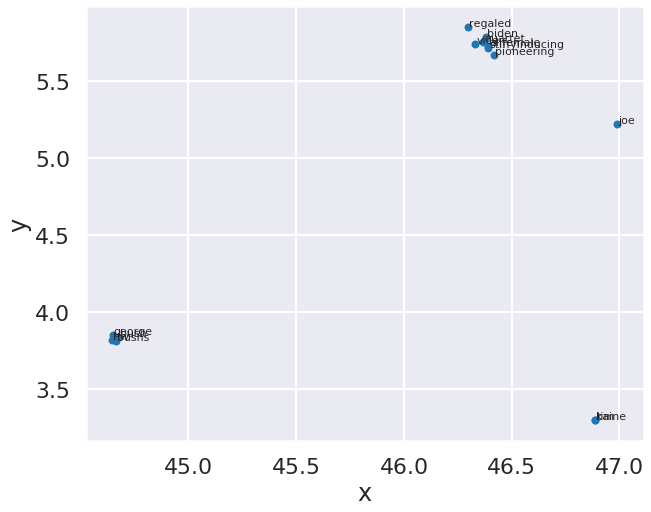

In [34]:
plot_region((44,47), (3,6))

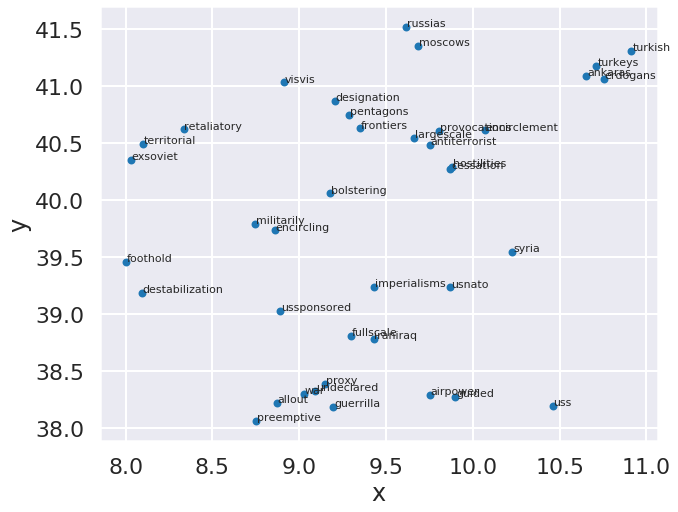

In [35]:
plot_region((8,11), (38,42))

In [36]:
# similar word relations
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = content2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [37]:
content2vec.most_similar('trump')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('donald', 0.6953704357147217),
 ('trumps', 0.6232800483703613),
 ('presumptive', 0.5781527161598206),
 ('presidentelects', 0.5427733659744263),
 ('temperamental', 0.5378267765045166),
 ('temperamentally', 0.5371404886245728),
 ('heil', 0.5368331670761108),
 ('madonna', 0.5307501554489136),
 ('bigot', 0.5275564789772034),
 ('antiestablishment', 0.524733304977417)]

In [38]:
nearest_similarity_cosmul("trump", "presidentelect", "clinton") # makes sense

trump is related to presidentelect, as hillary is related to clinton


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """


'hillary'